In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras import layers, Sequential
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Bidirectional, Input, Dense, Reshape, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# load label_xlsx

xlsx_name = '/content/drive/MyDrive/Project/HM10_label_p.xlsx'
xlsx_file = pd.read_excel(xlsx_name, usecols=[0, 1, 2])
xlsx_list = xlsx_file.values.tolist()
xlsx_list.sort()
print(xlsx_list)

random.seed(67)
random.shuffle(xlsx_list)

[['CG10_14972065_20221111_HM_1-10~20秒', 15, 15], ['CG10_14972065_20221111_HM_1-前10秒', 13, 13], ['CG10_14972065_20221111_HM_1-後10秒', 13, 13], ['CG10_14972065_20221209_HM_1-10~20秒', 15, 15], ['CG10_14972065_20221209_HM_1-前10秒', 16, 16], ['CG10_14972065_20221209_HM_1-後10秒', 16, 16], ['CG1_2934976_20211217_HM_1-10~20秒', 9, 9], ['CG1_2934976_20211217_HM_1-1~10秒', 9, 9], ['CG1_2934976_20211217_HM_1-後10秒', 9, 9], ['CG1_2934976_20220401_HM_2-10~20秒', 14, 14], ['CG1_2934976_20220401_HM_2-1~10秒', 15, 15], ['CG1_2934976_20220401_HM_2-後10秒', 12, 12], ['CG2_16112032_20220311_HM_1-10~20秒', 14, 14], ['CG2_16112032_20220311_HM_1-1~10秒', 14, 14], ['CG2_16112032_20220311_HM_1-後10秒', 13, 13], ['CG2_16112032_20220318_HM_2-10~20秒', 14, 15], ['CG2_16112032_20220318_HM_2-1~10秒', 14, 14], ['CG2_16112032_20220318_HM_2-後10秒', 14, 14], ['CG3_7590832_20220311_HM_1-10~20秒', 18, 18], ['CG3_7590832_20220311_HM_1-1~10秒', 18, 18], ['CG3_7590832_20220311_HM_1-後10秒', 17, 17], ['CG3_7590832_20220318_HM_2-10~20秒', 17, 17]

In [ ]:
# load sample_json

dataset_path = '/content/drive/MyDrive/Project/HM_dataset'

folders = os.listdir(dataset_path)
folders.sort()
random.seed(67)
random.shuffle(folders)
print(folders)

['CG4_4894520_20221110_HM_1-前10秒', 'CG5_14426070_20221209_HM_1-前10秒', 'TG3_3950401_20220301_HM_4-後10秒', 'CG2_16112032_20220318_HM_2-1~10秒', 'TG14_14287329_20220412_HM_1-1~10秒', 'TG18_4101222_20221118_HM_1-後10秒', 'TG23_4876786_20230221_HM_1-10~20秒', 'CG2_16112032_20220311_HM_1-1~10秒', 'TG2_11858195_20211125_HM_1-1~10秒', 'TG12_9135789_2022428_HM_2-10~20秒', 'CG5_14426070_20221209_HM_1-10~20秒', 'CG10_14972065_20221209_HM_1-後10秒', 'CG1_2934976_20220401_HM_2-後10秒', 'TG21_11881353_20230210_HM_1-後10秒', 'CG4_4894520_20221209_HM_1-10~20秒', 'TG21_11881353_20230210_HM_1-10~20秒', 'CG7_3332566_20221111_HM_1-前10秒', 'CG4_4894520_20221110_HM_1-後10秒', 'TG14_14287329_20220412_HM_1-後10秒', 'TG18_4101222_20221118_HM_1-10~20秒', 'TG3_3950401_20211207_HM_3-1~10秒', 'CG3_7590832_20220318_HM_2-10~20秒', 'CG8_6740498_20221111_HM_1-前10秒', 'TG6_9135789_20220112_HM_1-後10秒', 'CG2_16112032_20220311_HM_1-後10秒', 'TG7_13933678_20220324_HM_2-後10秒', 'TG3_3950401_20220301_HM_4-10~20秒', 'TG20_2101699_20221213_HM_1-10~20秒', 'TG

In [ ]:
X_folder_train, X_folder_test, y_folder_train, y_folder_test = train_test_split(folders, xlsx_list, test_size=0.2, random_state=42)

In [ ]:
def compute_distance(x1, y1, x2, y2):
  return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

In [ ]:
def read_json(train_test_list, dataset):
  for folder_name in dataset:
    folder_fullpath = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_fullpath):
      # print('Folder name:', folder_name)
      files = os.listdir(folder_fullpath)
      files.sort()
      
      hands_left_dist = []
      hands_right_dist = []
      for file_name in files:
        file_fullpath = os.path.join(folder_fullpath, file_name)
        if os.path.isfile(file_fullpath):
          os.chdir(folder_fullpath)
          json_file = pd.read_json(file_name)
          hand_left_dist = []
          hand_right_dist = []
          for i in range(12, 61, 12):
            hand_left_dist.append(compute_distance(json_file['people'][0]['hand_left_keypoints_2d'][0], json_file['people'][0]['hand_left_keypoints_2d'][1], json_file['people'][0]['hand_left_keypoints_2d'][i], json_file['people'][0]['hand_left_keypoints_2d'][i+1]))
            hand_right_dist.append(compute_distance(json_file['people'][0]['hand_right_keypoints_2d'][0], json_file['people'][0]['hand_right_keypoints_2d'][1], json_file['people'][0]['hand_right_keypoints_2d'][i], json_file['people'][0]['hand_right_keypoints_2d'][i+1]))
          hands_left_dist.append(hand_left_dist)
          hands_right_dist.append(hand_right_dist)
        else:
          print('Error: ' + file_name + 'is not a file.')
      
      train_test_list.append(hands_left_dist)
      train_test_list.append(hands_right_dist)
    
    else:
      print('Error: ' + folder_name + 'is not a folder.')

In [ ]:
X_train_original = []
X_test_original = []
y_train_original = []
y_test_original = []

read_json(X_train_original, X_folder_train)
read_json(X_test_original, X_folder_test)

for value in y_folder_train:
  y_train_original.append(value[1])
  y_train_original.append(value[2])

for value in y_folder_test:
  y_test_original.append(value[1])
  y_test_original.append(value[2])

print(len(X_train_original))
print(len(X_test_original))
print(len(y_train_original))
print(len(y_test_original))

296
76
296
76


In [ ]:
X_train_new = np.array(X_train_original)
X_test_new = np.array(X_test_original)
y_train_new = np.array(y_train_original)
y_test_new = np.array(y_test_original)

np.savetxt('/content/drive/MyDrive/Project/X_train_dist.txt', X_train_new.flatten())
np.savetxt('/content/drive/MyDrive/Project/X_test_dist.txt', X_test_new.flatten())
np.savetxt('/content/drive/MyDrive/Project/y_train_dist.txt', y_train_new.flatten())
np.savetxt('/content/drive/MyDrive/Project/y_test_dist.txt', y_test_new.flatten())

In [ ]:
loaded_array = np.loadtxt('/content/drive/MyDrive/Project/X_train_dist.txt')
X_train = loaded_array.reshape((296, 300, 5)).tolist()
print(len(X_train))
loaded_array = np.loadtxt('/content/drive/MyDrive/Project/X_test_dist.txt')
X_test = loaded_array.reshape((76, 300, 5)).tolist()
print(len(X_test))
loaded_array = np.loadtxt('/content/drive/MyDrive/Project/y_train_dist.txt')
y_train = loaded_array.reshape(296).tolist()
print(len(y_train))
loaded_array = np.loadtxt('/content/drive/MyDrive/Project/y_test_dist.txt')
y_test = loaded_array.reshape(76).tolist()
print(len(y_test))

296
76
296
76


In [ ]:
# Building the model
model = Sequential()
# Adding a Bidirectional LSTM layer
model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)) 
model.add(Bidirectional(CuDNNLSTM(128, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(CuDNNLSTM(32, return_sequences=True)))
model.add(Bidirectional(CuDNNLSTM(20)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

In [ ]:
# Validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)

In [ ]:
hist = model.fit( 
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    callbacks=early_stop,
    epochs=100,  
    batch_size=16
)

Epoch 1/100
15/15 [==============================] - 18s 171ms/step - loss: 156.8215 - val_loss: 122.3168
Epoch 2/100
15/15 [==============================] - 1s 67ms/step - loss: 93.2048 - val_loss: 79.8317
Epoch 3/100
15/15 [==============================] - 1s 68ms/step - loss: 60.9499 - val_loss: 53.5868
Epoch 4/100
15/15 [==============================] - 1s 66ms/step - loss: 42.7627 - val_loss: 40.0838
Epoch 5/100
15/15 [==============================] - 1s 67ms/step - loss: 32.6735 - val_loss: 31.7763
Epoch 6/100
15/15 [==============================] - 1s 66ms/step - loss: 26.4417 - val_loss: 26.2562
Epoch 7/100
15/15 [==============================] - 1s 97ms/step - loss: 22.0956 - val_loss: 22.4282
Epoch 8/100
15/15 [==============================] - 1s 78ms/step - loss: 19.1281 - val_loss: 19.4458
Epoch 9/100
15/15 [==============================] - 1s 67ms/step - loss: 16.8578 - val_loss: 17.2546
Epoch 10/100
15/15 [==============================] - 1s 68ms/step - loss: 15.

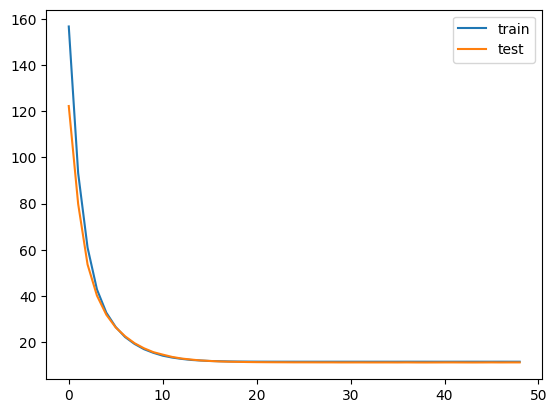

In [ ]:
from matplotlib import pyplot
pyplot.plot(hist.history['loss'], label='train')
pyplot.plot(hist.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
predict = model.predict(X_test)
print(predict)
print(y_test)

3/3 [==============================] - 1s 29ms/step
[[13.614823 ]
 [13.614824 ]
 [13.614814 ]
 [13.61482  ]
 [13.614799 ]
 [13.614809 ]
 [13.614827 ]
 [13.614825 ]
 [13.61483  ]
 [13.614824 ]
 [13.614824 ]
 [13.614822 ]
 [13.61483  ]
 [13.614824 ]
 [13.614818 ]
 [13.614823 ]
 [13.614826 ]
 [13.614827 ]
 [13.614823 ]
 [13.614822 ]
 [13.614818 ]
 [13.614825 ]
 [13.614829 ]
 [13.614832 ]
 [13.614823 ]
 [13.614832 ]
 [13.614831 ]
 [13.614829 ]
 [13.614819 ]
 [13.614816 ]
 [13.6148205]
 [13.6148205]
 [13.614825 ]
 [13.614825 ]
 [13.614828 ]
 [13.614823 ]
 [13.614831 ]
 [13.61483  ]
 [13.614821 ]
 [13.614827 ]
 [13.614832 ]
 [13.614832 ]
 [13.614815 ]
 [13.61482  ]
 [13.614827 ]
 [13.614822 ]
 [13.614824 ]
 [13.614828 ]
 [13.614817 ]
 [13.614817 ]
 [13.614823 ]
 [13.614821 ]
 [13.614823 ]
 [13.61483  ]
 [13.614828 ]
 [13.614826 ]
 [13.614803 ]
 [13.614824 ]
 [13.614804 ]
 [13.6148   ]
 [13.6148   ]
 [13.614798 ]
 [13.614796 ]
 [13.614808 ]
 [13.614827 ]
 [13.614813 ]
 [13.614824 ]
 [13.61482

In [ ]:
loss = model.evaluate(X_test, y_test)
print(loss)

3/3 [==============================] - 0s 56ms/step - loss: 14.0431
14.043088912963867
